In [29]:
import pickle as pkl
import pandas as pd
import matplotlib
import os
import re

import collections
import datetime
import time

import matplotlib.pyplot as plt
import seaborn as sns
    
import geopandas as gpd

import numpy as np

import rasterio

from difflib import get_close_matches

from fuzzywuzzy import process
from fuzzywuzzy import fuzz

import dask.dataframe as dd

import gc
import sys

from multiprocessing import Pool
import multiprocessing


# Sample

In [3]:
callLocation = '../../data/companyData/relevantZips.pkl'
file   = open(callLocation,"rb")
relevantZips = list(pkl.load(file))

len(relevantZips)

4538

In [4]:
def getData(weatherType,yearRange1,yearRange2):

    if weatherType == "Tmax":
        weatherVar = "temperature"
    else: 
        weatherVar = "precipitation"
    
    year = yearRange1
    filename = "../../../../../../../Volumes/backup2/dissData/prism/zipcode" + weatherType + str(year) + ".csv"
    data = dd.read_csv(filename, assume_missing=True)[['ZIP','date',weatherVar]]
    data['ZIP'] = data.ZIP.astype('int64')

    
    callLocation = '../../data/companyData/relevantZips.pkl'
    file   = open(callLocation,"rb")
    relevantZips = list(pkl.load(file))
    
    
    data = data[data.ZIP.isin(relevantZips)]
    
    # data = data[~(data[weatherVar].isna().compute())]

    years = range(yearRange1 + 1,yearRange2 + 1)
    for year in years:
        filename = "../../../../../../../Volumes/backup2/dissData/prism/zipcode" + weatherType + str(year) + ".csv"
        tempData = dd.read_csv(filename, assume_missing=True)[['ZIP','date',weatherVar]]
        tempData['ZIP'] = tempData.ZIP.astype('int64')

        tempData = tempData[tempData.ZIP.isin(relevantZips)]
        # tempData = tempData[~(tempData[weatherVar].isna().compute())]
        data = data.append(tempData)

    data = data[~(data[weatherVar].isna())].compute()
    
    return(data)


I think only a few of these quantiles will be relevant. Let's look at 0, 0.9, 0.95, 1.0

In [5]:
quantiles = [0.0, 0.05, 0.90, 0.95, 0.9888, 0.9973, 0.9978, 0.9989, 0.9995,  0.9997, 1.0]

# need to account for fact that once a year-quarter is 90 days, not 365
quant_labels = ['quant_0.05','quant_tossThisOne','quant_0.95','quant_1xQtr','quant_1xYr',
                'quant_1x5Qtrs','quant_1x10Qtrs','quant_1x5Yrs','quant_1x10Yrs','quant_1.0']

# Precipitation

In [6]:
weatherType = "Precip" # Tmax
precipData = getData(weatherType, 1981, 2008)

In [7]:
print(sys.getsizeof(precipData)/1e6)

1372.217984


In [8]:
len(precipData.ZIP.unique())

4193

## Temperature

In [9]:
weatherType = "Tmax"
tempData = getData(weatherType, 1981, 2008)

In [10]:
print(sys.getsizeof(tempData)/1e6)

1372.217984


In [15]:
precipData2 = getData("Precip", 2009, 2019)
tempData2   = getData("Tmax",   2009, 2019)

In [19]:
weatherData2 = tempData2.merge(precipData2)
weatherData2.head()

,ZIP,date,temperature,precipitation
0,1001,20090101.0,-2.941,4.491
1,1013,20090101.0,-3.683,4.403
2,1085,20090101.0,-4.804,4.008
3,1089,20090101.0,-3.892,3.613
4,1095,20090101.0,-4.128,5.737


Text(0, 0.5, 'Density')

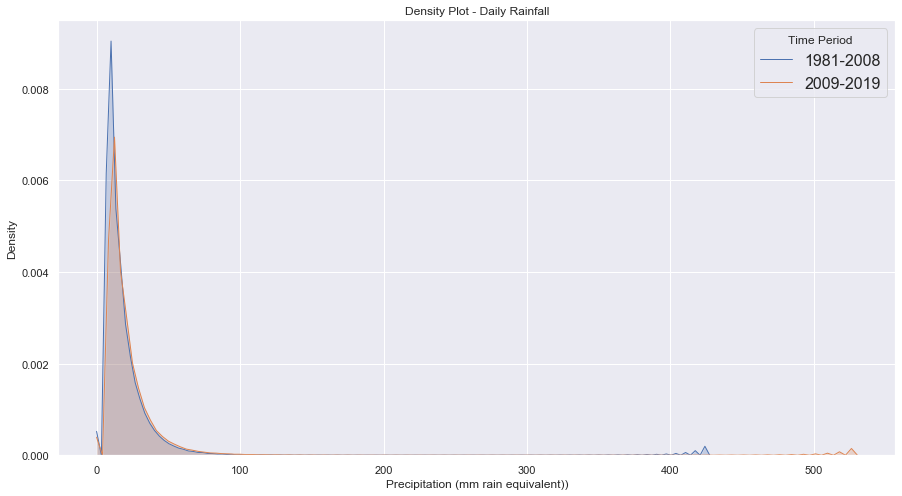

In [37]:
sns.set(rc = {'figure.figsize':(15,8)})

# Draw the density plot
sns.distplot(weatherData['precipitation'], hist = False, kde = True,
             kde_kws = {'linewidth': 1,'shade': True},
             label = '1981-2008')

sns.distplot(weatherData2['precipitation'], hist = False, kde = True,
             kde_kws = {'linewidth': 1,'shade': True},
             label = '2009-2019')
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Time Period')
plt.title('Density Plot - Daily Rainfall')
plt.xlabel('Precipitation (mm rain equivalent))')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

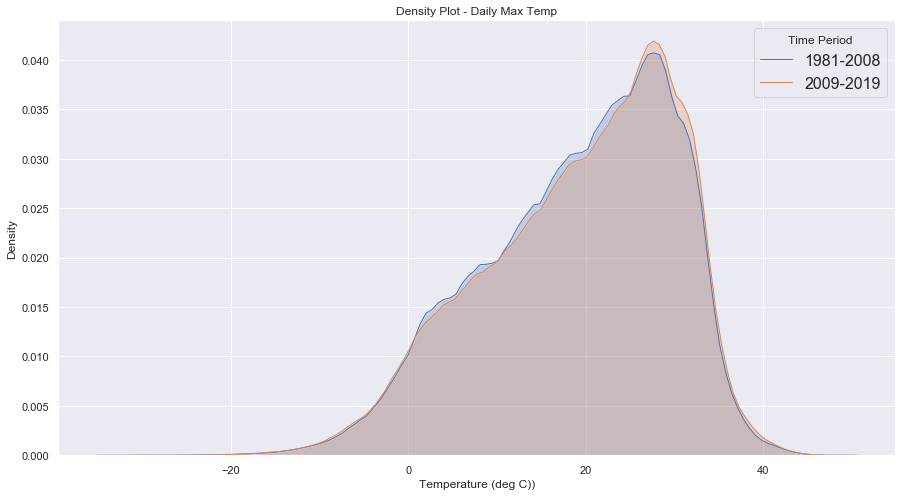

In [38]:
sns.set(rc = {'figure.figsize':(15,8)})

# Draw the density plot
sns.distplot(weatherData['temperature'], hist = False, kde = True,
             kde_kws = {'linewidth': 1,'shade': True},
             label = '1981-2008')

sns.distplot(weatherData2['temperature'], hist = False, kde = True,
             kde_kws = {'linewidth': 1,'shade': True},
             label = '2009-2019')
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Time Period')
plt.title('Density Plot - Daily Max Temp')
plt.xlabel('Temperature (deg C))')
plt.ylabel('Density')

In [46]:
print(weatherData['precipitation'].quantile(.95), weatherData2['precipitation'].quantile(.95))

16.0580005645752 17.2900009155273


In [47]:
print(weatherData['temperature'].quantile(.95), weatherData2['temperature'].quantile(.95))

33.5940017700195 33.8059997558594


## Get stats

### Describe Climate

In [51]:
weatherData = tempData.merge(precipData)
weatherData['month'] = weatherData.date.astype('str').str.slice(4,6)
weatherData['year'] = weatherData.date.astype('str').str.slice(0,4)

weatherData['quarter'] = 'q1'

weatherData.loc[weatherData['month'].isin(['04','05','06']), 'quarter'] = 'q2'
weatherData.loc[weatherData['month'].isin(['07','08','09']), 'quarter'] = 'q3'
weatherData.loc[weatherData['month'].isin(['10','11','12']), 'quarter'] = 'q4'
 
weatherData['temp5Days']   = weatherData.groupby('ZIP').rolling(5)['temperature'].mean().reset_index(drop=True)
weatherData['precip5Days'] = weatherData.groupby('ZIP').rolling(5)['precipitation'].sum().reset_index(drop=True)
    
print(weatherData.shape,tempData.shape,precipData.shape)


weatherData.head()

,ZIP,date,temperature,precipitation,month,year,quarter,temp5Days,precip5Days
0,1001,19810101.0,-5.148,0.0,01,1981,q1,NaN,NaN
1,1013,19810101.0,-5.249,0.0,01,1981,q1,NaN,NaN
2,1085,19810101.0,-5.579,0.0,01,1981,q1,NaN,NaN
3,1089,19810101.0,-5.378,0.0,01,1981,q1,NaN,NaN
4,1095,19810101.0,-5.814,0.0,01,1981,q1,-8.1044,1.613


In [49]:
del tempData
del precipData
gc.collect()

NameError: name 'tempData' is not defined

In [52]:
len(weatherData.ZIP.unique())

4193

Get the quarterly stats.

In [ ]:
quarterlyStatsOverall = weatherData.drop(columns = {'date'}).\
    groupby(['quarter']).\
    agg(quarterly_avg_precip = ('precipitation',"mean"),
       quarterly_median_precip = ('precipitation',"median"),
       quarterly_variance_precip = ('precipitation',"var"),
       quarterly_avg_temp = ('temperature',"mean"),
       quarterly_median_temp = ('temperature',"median"),
       quarterly_variance_temp = ('temperature',"var")
       ).reset_index()

quarterlyStatsByZip = weatherData.drop(columns = {'date'}).\
    groupby(['ZIP','quarter']).\
    agg(quarterly_avg_precip = ('precipitation',"mean"),
       quarterly_median_precip = ('precipitation',"median"),
       quarterly_variance_precip = ('precipitation',"var"),
       quarterly_avg_temp = ('temperature',"mean"),
       quarterly_median_temp = ('temperature',"median"),
       quarterly_variance_temp = ('temperature',"var")
       ).reset_index()

'''
precipQuantsOverall = precipData.groupby(['month']).precipitation.quantile(q = quantiles).\
    reset_index().rename(columns = {'level_1': 'quantile'})
'''


In [ ]:
quarterlyStatsByZip.to_csv("../../data/companyData/quarterlyStatsByZip.csv")

And the annual ones.

In [ ]:
annualStatsOverall = weatherData.drop(columns = {'date'}).\
    groupby(['year']).\
    agg(annual_avg_precip = ('precipitation',"mean"),
       annual_median_precip = ('precipitation',"median"),
       annual_variance_precip = ('precipitation',"var"),
       annual_avg_temp = ('temperature',"mean"),
       annual_median_temp = ('temperature',"median"),
       annual_variance_temp = ('temperature',"var")
       ).reset_index()

annualStatsByZip = weatherData.drop(columns = {'date'}).\
    groupby(['ZIP','year']).\
    agg(annual_avg_precip = ('precipitation',"mean"),
       annual_median_precip = ('precipitation',"median"),
       annual_variance_precip = ('precipitation',"var"),
       annual_avg_temp = ('temperature',"mean"),
       annual_median_temp = ('temperature',"median"),
       annual_variance_temp = ('temperature',"var")
       ).reset_index()
annualStatsByZip.head()

In [ ]:
quarterlyStatsByZip.head()

In [ ]:
del quarterlyStatsByZip
del annualStatsByZip
gc.collect()

### Find Quartiles

In [53]:
def getPivotQuantsOverall(weatherType,weatherData):

    quants_overall  =  weatherData[weatherType].quantile(q = quantiles).reset_index().\
        rename(columns = {'index': 'quartile'})    
    
    quants_overall['quartile'] = 'q_' + quants_overall['quartile'].astype(str).str.slice(0,6)
    quants_overall = quants_overall.iloc[:,1:].values.flatten().tolist()

    return(quants_overall)

In [54]:
def getPivotQuants(weatherType, identifiers,weatherData):

    quants_overallByZip   = weatherData.groupby(identifiers)[weatherType].quantile(q = quantiles).reset_index().\
        rename(columns=lambda x: re.sub('level_[0-9]$','quartile',x))
    # rename(columns = {'level_1': 'quartile'})
    # print(quants_overallByZip.head())
    
    quants_overallByZip['quartile'] = 'q_' + quants_overallByZip['quartile'].astype(str).str.slice(0,6)

    ## 

    pivot_quants_overallByZip = quants_overallByZip.pivot(index=identifiers, 
            columns='quartile', values=str(weatherType)).reset_index().\
            rename_axis(None, axis=1)

    pivot_quants_overallByZip['quartileList']      = pivot_quants_overallByZip.iloc[:,len(identifiers):].values.tolist()
    pivot_quants_overallByZip['quartileLabelList'] = [list(pivot_quants_overallByZip.columns[2:-1])] * \
                                                                    pivot_quants_overallByZip.shape[0]

    pivot_quants_overallByZip = pivot_quants_overallByZip[pivot_quants_overallByZip.\
                                                            columns.drop(list(pivot_quants_overallByZip.filter(regex='q_')))]

    # pivot_quants_overallByZip.head()

    return(pivot_quants_overallByZip)

In [55]:
def getQuartCounts(df, weatherType):
    weatherCut = weatherType + "Cut"
    weatherCutLabels = weatherCut + 'labels'
    
    df['month'] = df.date.astype(str).str.slice(4,6)
    
    df['quarter'] = 'q1'

    df.loc[df['month'].isin(['04','05','06']), 'quarter'] = 'q2'
    df.loc[df['month'].isin(['07','08','09']), 'quarter'] = 'q3'
    df.loc[df['month'].isin(['10','11','12']), 'quarter'] = 'q4'

    df['yearQuarter'] = df.date.astype(str).str.slice(0,4) + df.quarter

    occurrences = weatherType + "Occurrences" 

    summaryDF = df.groupby(['ZIP','yearQuarter',weatherCutLabels]).size().reset_index()
    summaryDF.columns = ['zip','yearQuarter',weatherCutLabels,occurrences]
    
    return(summaryDF)

Now get all the quartile data:
    - Overall
    - By zip
    - Quarterly by zip

In [57]:
tempQuants   = getPivotQuantsOverall('temperature',weatherData)
tempQuants

[-34.1430015563965,
 0.0410000011324883,
 31.7670001983643,
 33.5940017700195,
 37.1129989624023,
 40.4129981994629,
 40.8310012817383,
 42.0229988098145,
 43.1110000610352,
 43.7060012817383,
 49.6259994506836]

In [59]:
quant_labels

['quant_0.05',
 'quant_tossThisOne',
 'quant_0.95',
 'quant_1xQtr',
 'quant_1xYr',
 'quant_1x5Qtrs',
 'quant_1x10Qtrs',
 'quant_1x5Yrs',
 'quant_1x10Yrs',
 'quant_1.0']

In [58]:
tempQuants2   = getPivotQuantsOverall('temperature',weatherData2)
tempQuants2

[-30.0440006256104,
 -0.129999995231628,
 32.0029983520508,
 33.8059997558594,
 37.4669990539551,
 40.5970001220703,
 40.9780006408691,
 42.0839996337891,
 43.1720008850098,
 43.78401638793834,
 48.8460006713867]

In [ ]:
###################
# OVERALL
tempQuants   = getPivotQuantsOverall('temperature',weatherData)
precipQuants = getPivotQuantsOverall('precipitation',weatherData)

temp5DaysQuants   = getPivotQuantsOverall('temp5Days',weatherData)
precip5DaysQuants = getPivotQuantsOverall('precip5Days',weatherData)



####################
# BY ZIP
pivot_temperatureQuants_zip = getPivotQuants('temperature',['ZIP'],weatherData).\
    drop(columns = {'quartileLabelList'})
pivot_temperatureQuants_zip.rename(columns = {'quartileList':     'quartileListTemperature_zip'},
                                      inplace = True)

pivot_temp5DaysQuants_zip = getPivotQuants('temp5Days',['ZIP'],weatherData).\
    drop(columns = {'quartileLabelList'})
pivot_temp5DaysQuants_zip.rename(columns = {'quartileList':     'quartileListTemp5Days_zip'},
                                      inplace = True)



pivot_precipitationQuants_zip = getPivotQuants('precipitation',['ZIP'],weatherData).\
    drop(columns = {'quartileLabelList'})
pivot_precipitationQuants_zip.rename(columns = {'quartileList':     'quartileListPrecipitation_zip'},
                                      inplace = True)

pivot_precip5DaysQuants_zip = getPivotQuants('precip5Days',['ZIP'],weatherData).\
    drop(columns = {'quartileLabelList'})
pivot_precip5DaysQuants_zip.rename(columns = {'quartileList':     'quartileListPrecip5Days_zip'},
                                      inplace = True)


quants_zip = pivot_temperatureQuants_zip.merge(pivot_precipitationQuants_zip).merge(pivot_temp5DaysQuants_zip).merge(pivot_precip5DaysQuants_zip)



##########################################
# BY ZIP-QUARTER
pivot_temperatureQuants_quarterlyByZip = getPivotQuants('temperature',['ZIP','quarter'],weatherData).\
    drop(columns = {'quartileLabelList'})
pivot_temperatureQuants_quarterlyByZip.rename(columns = {'quartileList':     'quartileListTemperature_quarterlyByZip'},
                                      inplace = True)
pivot_temp5DaysQuants_quarterlyByZip = getPivotQuants('temp5Days',['ZIP','quarter'],weatherData).\
    drop(columns = {'quartileLabelList'})
pivot_temp5DaysQuants_quarterlyByZip.rename(columns = {'quartileList':     'quartileListTemp5Days_quarterlyByZip'},
                                      inplace = True)



pivot_precipitationQuants_quarterlyByZip = getPivotQuants('precipitation',['ZIP','quarter'],weatherData).\
    drop(columns = {'quartileLabelList'})
pivot_precipitationQuants_quarterlyByZip.rename(columns = {'quartileList':     'quartileListPrecipitation_quarterlyByZip'},
                                      inplace = True)
pivot_precip5DaysQuants_quarterlyByZip = getPivotQuants('precip5Days',['ZIP','quarter'],weatherData).\
    drop(columns = {'quartileLabelList'})
pivot_precip5DaysQuants_quarterlyByZip.rename(columns = {'quartileList':     'quartileListPrecip5Days_quarterlyByZip'},
                                      inplace = True)


quants_quarterlyByZip = pivot_temperatureQuants_quarterlyByZip.merge(pivot_precipitationQuants_quarterlyByZip).merge(pivot_temp5DaysQuants_quarterlyByZip).merge(pivot_precip5DaysQuants_quarterlyByZip)



Construct a record of all the relevant quantiles by combining all of the above. Rough idea is:
    - Start with the zip-quarter data
    - Merge in the less-specific quarter information
    - For each row, put in the overall quartile information for each row

In [ ]:
quantsAll                 = quants_quarterlyByZip.merge(quants_zip)



quantsAll['precipitationQuants'] = [precipQuants for i in quantsAll.index]
quantsAll['temperatureQuants']   = [tempQuants   for i in quantsAll.index]



quantsAll['precip5DaysQuants']   = [precip5DaysQuants for i in quantsAll.index]
quantsAll['temp5DaysQuants']     = [temp5DaysQuants   for i in quantsAll.index]



quantsAll.head()

In [ ]:
# relevantZips = allCustomerData.zipcode.append(allSupplierData.zipcode).unique()
outfile =  '../../data/companyData/quantsAll.pkl'
with open(outfile, 'wb') as pickle_file:
    pkl.dump(quantsAll, pickle_file)

In [ ]:
del weatherData
gc.collect()

### Convert 2009-2018 data into quartiles

In [ ]:
recentDecadeTmax   = getData("Tmax",2009,2019)
recentDecadePrecip = getData("Precip",2009,2019)

In [ ]:
recentDecadeWeather = recentDecadeTmax.merge(recentDecadePrecip)
recentDecadeWeather.head()

In [ ]:
recentDecadeWeather['month'] = recentDecadeWeather.date.astype(str).str.slice(4,6)

recentDecadeWeather['quarter'] = 'q1'

recentDecadeWeather.loc[recentDecadeWeather['month'].isin(['04','05','06']), 'quarter'] = 'q2'
recentDecadeWeather.loc[recentDecadeWeather['month'].isin(['07','08','09']), 'quarter'] = 'q3'
recentDecadeWeather.loc[recentDecadeWeather['month'].isin(['10','11','12']), 'quarter'] = 'q4'

recentDecadeWeather['yearQuarter'] = recentDecadeWeather.date.astype(str).str.slice(0,4) + recentDecadeWeather.quarter
recentDecadeWeather.head()

In [ ]:
recentDecadeWeather['temp5Days']   = recentDecadeWeather.groupby('ZIP').rolling(5)['temperature'].mean().reset_index(drop=True)
recentDecadeWeather['precip5Days'] = recentDecadeWeather.groupby('ZIP').rolling(5)['precipitation'].sum().reset_index(drop=True)

In [ ]:
del recentDecadePrecip
del recentDecadeTmax
gc.collect()

recentDecadeWeather[recentDecadeWeather.yearQuarter == '2010q1']

Merge the intervals into the recent weather data.

In [ ]:
quantsAll.columns

In [ ]:
recentDecadeWeather.columns

In [ ]:
recentDecadeWeather = recentDecadeWeather.merge(quantsAll)

recentDecadeWeather.head()

Get the annual quants.

In [ ]:
recentDecadeWeather.temperatureQuants[0]

In [ ]:
for i in range(0,len(recentDecadeWeather.temp_annualQuants[0])):
    recentDecadeWeather.temperatureQuants[0][i]   = recentDecadeWeather.temperatureQuants[0][i] + i/10000
    recentDecadeWeather.temp5DaysQuants[0][i]     = recentDecadeWeather.temp5DaysQuants[0][i] + i/10000
    
    recentDecadeWeather.precipitationQuants[0][i] = recentDecadeWeather.precipitationQuants[0][i] + i/10000
    recentDecadeWeather.precip5DaysQuants[0][i]   = recentDecadeWeather.precip5DaysQuants[0][i] + i/10000


In [ ]:
recentDecadeWeather['temp_annualQuants'] = pd.cut(recentDecadeWeather.temperature, 
           bins = recentDecadeWeather.temperatureQuants[0],
           labels = quant_labels,include_lowest=True)
recentDecadeWeather['temp5Days_annualQuants'] = pd.cut(recentDecadeWeather.temp5Days, 
           bins = recentDecadeWeather.temp5DaysQuants[0],
           labels = quant_labels,include_lowest=True)

recentDecadeWeather['precip_annualQuants'] = pd.cut(recentDecadeWeather.precipitation, 
           bins = recentDecadeWeather.precipitationQuants[0],
           labels = quant_labels,include_lowest=True)

recentDecadeWeather['precip5Days_annualQuants'] = pd.cut(recentDecadeWeather.precip5Days, 
           bins = recentDecadeWeather.precip5DaysQuants[0],
           labels = quant_labels,include_lowest=True)

recentDecadeWeather.head()


Now do the same but for zips. For some reason the filtering operations are like 10x faster with making the ZIP and quarter out to be categories.

In [ ]:
recentDecadeWeather = recentDecadeWeather.astype({'ZIP': 'category', 'quarter': 'category'})

In [ ]:
def getZipQuarts(zipcode):
    
    tempData = recentDecadeWeather[recentDecadeWeather.ZIP == zipcode].reset_index()
    
    if tempData.shape[0] > 0:


        for i in range(0,len(tempData.quartileListPrecip5Days_zip[0])):
                tempData.quartileListPrecipitation_zip[0][i] = tempData.quartileListPrecipitation_zip[0][i] + i/10000
                tempData.quartileListPrecip5Days_zip[0][i]   = tempData.quartileListPrecip5Days_zip[0][i] + i/10000


        tempData['temp_zipQuants'] = pd.cut(tempData.temperature, 
               bins = tempData.quartileListTemperature_zip[0],
               labels = quant_labels,include_lowest=True)
        tempData['temp5Days_zipQuants'] = pd.cut(tempData.temp5Days, 
               bins = tempData.quartileListTemp5Days_zip[0],
               labels = quant_labels,include_lowest=True)


        tempData['precip_zipQuants'] = pd.cut(tempData.precipitation, 
               bins = tempData.quartileListPrecipitation_zip[0],
               labels = quant_labels,include_lowest=True)

        tempData['precip5Days_zipQuants'] = pd.cut(tempData.precip5Days, 
               bins = tempData.quartileListPrecip5Days_zip[0], 
               labels = quant_labels,include_lowest=True)
        
    
    
    return(tempData)

In [ ]:
def getZipQuarterQuarts(zipcode):

    weatherByZipByQuarter = pd.DataFrame()

    quarters = recentDecadeWeather.quarter.unique()
    

    for quarter in quarters:
        tempData = recentDecadeWeather[(recentDecadeWeather.ZIP  == zipcode) & 
                        (recentDecadeWeather.quarter == quarter)].reset_index()
        if tempData.shape[0] > 0:

            for i in range(0,len(tempData.quartileListPrecip5Days_quarterlyByZip[0])):
                tempData.quartileListPrecipitation_quarterlyByZip[0][i] = tempData.quartileListPrecipitation_quarterlyByZip[0][i] + i/10000
                tempData.quartileListPrecip5Days_quarterlyByZip[0][i]   = tempData.quartileListPrecip5Days_quarterlyByZip[0][i] + i/10000
                tempData.quartileListTemperature_quarterlyByZip[0][i] = tempData.quartileListTemperature_quarterlyByZip[0][i] + i/10000
                tempData.quartileListTemp5Days_quarterlyByZip[0][i]   = tempData.quartileListTemp5Days_quarterlyByZip[0][i] + i/10000


            tempData['temp_zipQuarterQuants'] = pd.cut(tempData.temperature, 
                   bins = tempData.quartileListTemperature_quarterlyByZip[0],
                   labels = quant_labels,include_lowest=True)
            tempData['temp5Days_zipQuarterQuants'] = pd.cut(tempData.temp5Days, 
                   bins = tempData.quartileListTemp5Days_quarterlyByZip[0],
                   labels = quant_labels,include_lowest=True)


            tempData['precip_zipQuarterQuants'] = pd.cut(tempData.precipitation, 
                   bins = tempData.quartileListPrecipitation_quarterlyByZip[0],
                   labels = quant_labels,include_lowest=True)
            tempData['precip5Days_zipQuarterQuants'] = pd.cut(tempData.precip5Days, 
                   bins = tempData.quartileListPrecip5Days_quarterlyByZip[0], 
                   labels = quant_labels,include_lowest=True) # 


            weatherByZipByQuarter = weatherByZipByQuarter.append(tempData)

    return(weatherByZipByQuarter)

In [ ]:
ZIPs = recentDecadeWeather.ZIP.unique()
len(ZIPs)

In [ ]:
start = time.time()




with multiprocessing.Pool() as pool:
    zipQuarts = pool.map(getZipQuarts, ZIPs)

    
    
weatherByZip = pd.concat(zipQuarts)


print(time.time() - start)

In [ ]:
start = time.time()



with multiprocessing.Pool() as pool:
    zipQuarterQuarts = pool.map(getZipQuarterQuarts, ZIPs)

    
    
weatherByZipQuarter = pd.concat(zipQuarterQuarts)


print(time.time() - start)

In [ ]:
weatherByZipQuarter['yearQuarter'] = weatherByZipQuarter.date.astype('str').str.slice(0,4) + weatherByZipQuarter.quarter.astype('str')
weatherByZip['yearQuarter']        = weatherByZip.date.astype('str').str.slice(0,4) + weatherByZip.quarter.astype('str')

In [ ]:
pt1 = weatherByZip[['ZIP','date','quarter','yearQuarter',
              'temp_annualQuants', 'temp5Days_annualQuants',
              'precip_annualQuants', 'precip5Days_annualQuants', 
              'temp_zipQuants', 'temp5Days_zipQuants',
              'precip_zipQuants', 'precip5Days_zipQuants']]

pt2 = weatherByZipQuarter[['ZIP','date','quarter','yearQuarter',
                           'temp_zipQuarterQuants','temp5Days_zipQuarterQuants', 
                     'precip_zipQuarterQuants','precip5Days_zipQuarterQuants']]


outfile =  '../../data/companyData/pt1.pkl'
with open(outfile, 'wb') as pickle_file:
    pkl.dump(pt1, pickle_file)
    
outfile =  '../../data/companyData/pt2.pkl'
with open(outfile, 'wb') as pickle_file:
    pkl.dump(pt2, pickle_file)




In [ ]:
allQuarts = pt1.merge(pt2)

In [ ]:
allQuarts.head()

------------------

### Now go through the data from 2010 - 2019 and find time spent in each bin

In [ ]:
def getCounts(quartType,df):

    test = df.groupby(['ZIP','yearQuarter',quartType]).size().reset_index()
    test = test.drop_duplicates()
    test.columns = ['zip', 'yearQuarter', quartType, 'occurrences']

    # print(test.head())


    testPivot = test.pivot(index=['zip','yearQuarter'], 
            columns = quartType, values= 'occurrences').reset_index().\
            rename_axis(None, axis=1)

    testPivot.columns.values[2:] = quartType[:-6] + testPivot.columns.values[2:]

    # print(testPivot.head())
    return(testPivot)

In [ ]:
allQuarts

In [ ]:
countData = getCounts(allQuarts.columns[4],allQuarts)

for quart in allQuarts.columns[5:]:
    print(quart)
    countData = countData.merge(getCounts(quart,allQuarts))

In [ ]:
print(countData.columns)

Reformat the column names so they're consistent.

In [ ]:
countData['year'] = countData.yearQuarter.str.slice(0,4)
countData['qtr']  = countData.yearQuarter.str.slice(5,6).astype('float')
countData['zipcode']  = countData.zip.astype('int64')

In [ ]:
countData.zipcode.min()

In [ ]:
countData.head()

In [ ]:
countData.to_csv("../../data/companyData/allWeatherBins_2009to2019.csv")

In [ ]:
len(countData.zipcode.unique())

In [ ]:
countData.columns

In [ ]:
'''countData = pd.read_csv("../../data/companyData/allWeatherBins_2009to2019.csv").drop(columns = 'Unnamed: 0')

countData.head()'''

countDataRevised = countData[['zipcode','year','qtr']]


In [ ]:

cdf = {}


cdf['0.95']     = ['1xQtr','1xYr','1x5Qtrs','1x10Qtrs','1x5Yrs','1x10Yrs','1.0']
cdf['1xQtr']    = ['1xYr','1x5Qtrs','1x10Qtrs','1x5Yrs','1x10Yrs','1.0']
cdf['1xYr']     = ['1x5Qtrs','1x10Qtrs','1x5Yrs','1x10Yrs','1.0']
cdf['1x5Qtrs']  = ['1x10Qtrs','1x5Yrs','1x10Yrs','1.0']
cdf['1x10Qtrs'] = ['1x5Yrs','1x10Yrs','1.0']
cdf['1x5Yrs']   = ['1x10Yrs','1.0']
cdf['1x10Yrs']  = ['1.0']


weatherVars = ['precip_','temp_','precip5Days_','temp5Days_']
statVars    = ['annualquant_','zipquant_','zipQuarterquant_']


for weatherVar in weatherVars:
    for statVar in statVars:
        print(weatherVar + statVar, "*************************")
        
        # 0.95
        for cutoff in list(cdf.keys()):
            
            varHere = weatherVar + statVar + cutoff
            countDataRevised[varHere] = countData[varHere]
            print(cutoff, "******")
            for greaterThanCutoffs in cdf[cutoff]:
                varCDF = weatherVar + statVar + greaterThanCutoffs 
                countDataRevised[varHere] = countDataRevised[varHere] + countData[varCDF] 
                print(weatherVar + statVar + greaterThanCutoffs)
 

In [ ]:
countDataRevised['temp_annualquant_0.95']

In [ ]:
countData['temp_annualquant_0.95']

In [ ]:
countDataRevised.to_csv("../../data/companyData/revised_allWeatherBins_2009to2019.csv")

In [ ]:
countDataRevised = pd.read_csv("../../data/companyData/revised_allWeatherBins_2009to2019.csv")

In [ ]:
countDataRevised['temp5Days_zipquant_0.95'].describe()